In [1]:
# 1. Install Dependencies and Setup
%pip install tensorflow tensorflow-gpu opencv-python matplotlib
%pip list

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu


Package                      Version
---------------------------- -----------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
autopep8                     2.0.0
backcall                     0.2.0
beautifulsoup4               4.11.1
blinker                      1.6.2
bs4                          0.0.1
cachetools                   5.3.0
certifi                      2022.12.7
charset-normalizer           3.0.1
click                        8.1.3
colorama                     0.4.6
comm                         0.1.3
confusion-matrix             0.1
contourpy                    1.0.7
cycler                       0.11.0
dabl                         0.2.5
debugpy                      1.6.7
decorator                    5.1.1
dill                         0.3.6
dm-tree                      0.1.8
etils                        1.0.0
executing                    1.2.0
filelock                     3.12.0
Flask                        2.3.2
flatbuf

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')


[]

In [4]:
# 2. Remove dodgy images
import cv2
import imghdr
data_dir = 'SKCD'
image_exts = ['jpeg', 'jpg', 'bmp', 'png', 'svg']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

C:\Users\ADEBOSS\AppData\Local\Temp\ipykernel_11344\3159287028.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Found 1154 files belonging to 4 classes.


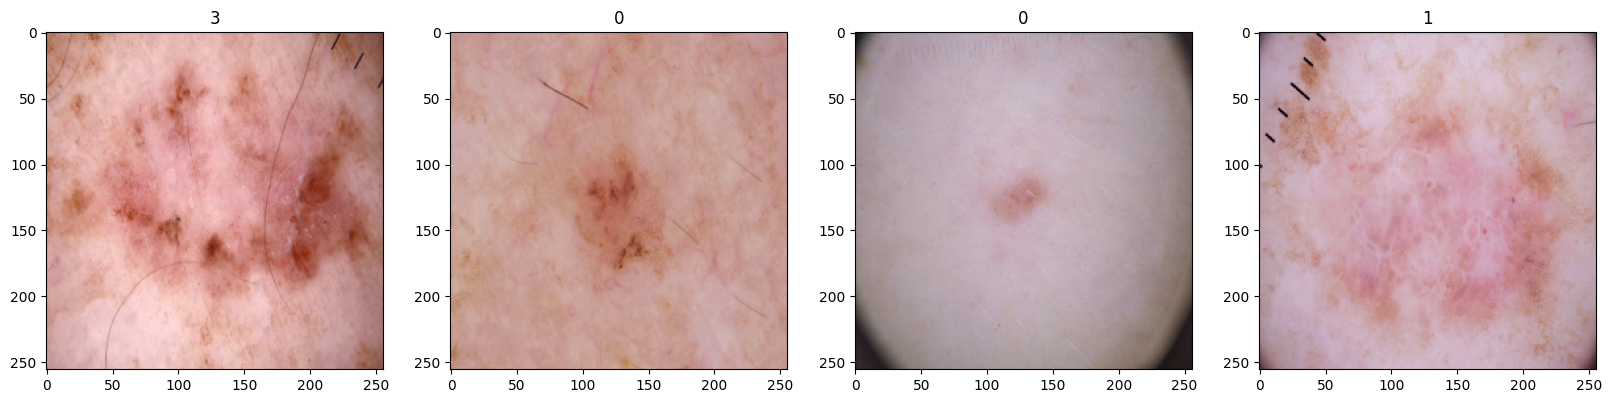

In [5]:
# 3. Load Data
import numpy as np
from matplotlib import pyplot as plt
data = tf.keras.utils.image_dataset_from_directory('SKCD', labels='inferred', label_mode='int')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
plt.show()

In [6]:
# 4. Scale Data
data = data.map(lambda x, y: (x / 255, y))
data.as_numpy_iterator().next()


(array([[[[0.6936301 , 0.6284874 , 0.6410513 ],
          [0.693244  , 0.63439727, 0.646162  ],
          [0.6995251 , 0.63678   , 0.6485447 ],
          ...,
          [0.6453082 , 0.5722077 , 0.5546176 ],
          [0.640748  , 0.58171743, 0.56989145],
          [0.62796175, 0.57389706, 0.55562454]],
 
         [[0.6984296 , 0.63604474, 0.64780945],
          [0.7013717 , 0.64195913, 0.65372384],
          [0.70055145, 0.63780636, 0.64957106],
          ...,
          [0.6577577 , 0.5860665 , 0.5651219 ],
          [0.64486825, 0.58479697, 0.55751306],
          [0.62888354, 0.57460916, 0.5527267 ]],
 
         [[0.6927696 , 0.63381034, 0.64557505],
          [0.70149237, 0.6388021 , 0.6505668 ],
          [0.6900276 , 0.6307904 , 0.6425551 ],
          ...,
          [0.65669256, 0.58949596, 0.56078434],
          [0.64099264, 0.5812194 , 0.56068116],
          [0.63672304, 0.5778995 , 0.5630055 ]],
 
         ...,
 
         [[0.63685876, 0.55699843, 0.55307686],
          [0.64729

In [7]:
# 5. Split Data
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)
train_size, val_size, test_size

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)


In [8]:
# 6. Build Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [9]:
model = Sequential()
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 4 output classes
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [10]:
# 7. Train
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/30
25/25 [==============================] - 79s 3s/step - loss: 1.3720 - accuracy: 0.3587 - val_loss: 1.2874 - val_accuracy: 0.3929
Epoch 2/30
25/25 [==============================] - 71s 3s/step - loss: 1.2920 - accuracy: 0.3787 - val_loss: 1.2033 - val_accuracy: 0.4375
Epoch 3/30
25/25 [==============================] - 72s 3s/step - loss: 1.2151 - accuracy: 0.4162 - val_loss: 1.1285 - val_accuracy: 0.4598
Epoch 4/30
25/25 [==============================] - 71s 3s/step - loss: 1.0961 - accuracy: 0.5512 - val_loss: 0.9662 - val_accuracy: 0.6071
Epoch 5/30
25/25 [==============================] - 75s 3s/step - loss: 1.0361 - accuracy: 0.5825 - val_loss: 0.9582 - val_accuracy: 0.6429
Epoch 6/30
25/25 [==============================] - 71s 3s/step - loss: 0.9530 - accuracy: 0.6150 - val_loss: 0.8119 - val_accuracy: 0.7098
Epoch 7/30
25/25 [==============================] - 73s 3s/step - loss: 0.9048 - accuracy: 0.6438 - val_loss: 0.9525 - val_accuracy: 0.5893
Epoch 8/30
25/25 [==

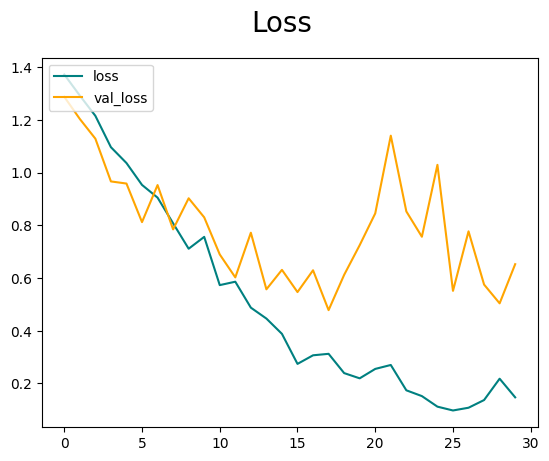

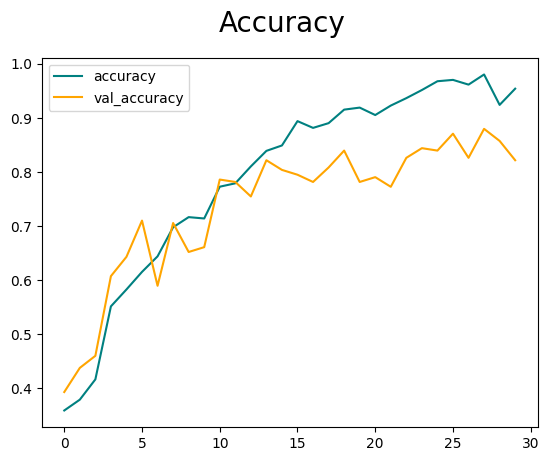

In [11]:
# 8. Plot Performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [12]:
# 9. Evaluate
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_classes = np.argmax(yhat, axis=-1)  # Get the predicted class indices
    
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)
print(pre.result(), re.result(), acc.result())


1/1 [==============================] - 1s 561ms/step
tf.Tensor(0.8095238, shape=(), dtype=float32) tf.Tensor(0.85, shape=(), dtype=float32) tf.Tensor(0.32291666, shape=(), dtype=float32)


In [13]:
# 10. Test
import cv2

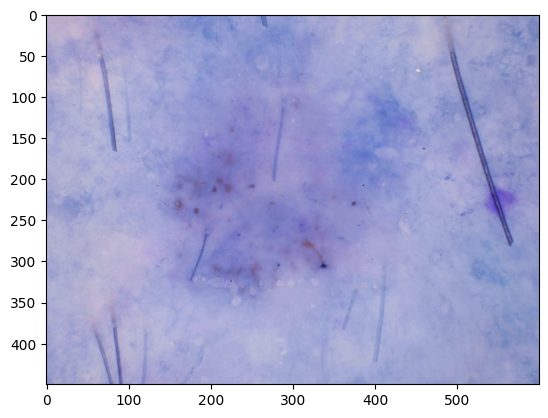

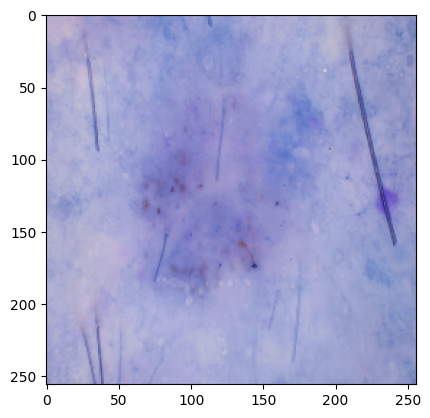

1/1 [==============================] - 0s 206ms/step
Predicted class is a Basal cell Carcinoma


In [14]:
img = cv2.imread('SKCD/basal cell carcinoma/ISIC_0024331.jpg')
plt.imshow(img)
plt.show()

resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize / 255, 0))
predicted_class = np.argmax(yhat)  # Get the index of the highest probability class
classes = ['Basal cell Carcinoma', 'Dermatofibroma', 'Melanoma', 'Squamous cell carcinoma']
print(f'Predicted class is a {classes[predicted_class]}')

In [15]:
# 11. Save the Model
from tensorflow.keras.models import load_model

model.save(os.path.join('models', 'imageclassifier.h5'))
new_model = load_model('models/imageclassifier.h5')
new_model.predict(np.expand_dims(resize / 255, 0))


1/1 [==============================] - 0s 123ms/step


array([[0.9540583 , 0.02010472, 0.02396998, 0.00186711]], dtype=float32)